Author: Alexander Hoogsteyn \
Date: 19th September 2023

# Introduction to distributed optimization in energy system modelling
The energy transition is changing our power system from a top-down system with central generation of electricity to one with an increased number of distributed generation assets such as PV systems. Increased penetration of renewables is creating a drive to invest in more interconnection capacity to use for cross-border trade. Emerging technologies such as hydrogen and renewable gas and renewable heat are coupling sectors. These factors are increasing the complexity of energy models that aim to study the effects of the energy transition substantially. This is creating a need to improve the algorithms being employed in energy system modelling.

A common approach to keep increasingly complex optimization problems computationally tractable is to split the single optimization problem into pieces that represent single actors in the energy system and solve it using a distributed optimization method. This notebook aims to give a brief introduction to distributed ADMM (or dADMM), a commenly used distributed optimization technique. dADMM is applicable to a wide range of applications, energy system modelling being one of them.

Besides the computational argument, there is another reason a modeller might prefer to use a distributed formulation of an optimization problem. In energy system modelling, most commenly, the "central planner perspective" is used to model energy markets in which one central planner aims to minimize the costs of the system. However, a modeler can also take an "multi-agent equilibrium perspective" in which all participants in the market aim to maximize their profit. Such a "equilibrium model" formulation resembles micro-economic problems more closely and allows more modelling freedom in implementing distortions to the decision making of the agents.

The "central planner perspective" and "multi-agent equilibrium perspective" lead to the same optimum, under certain conditions, and in that case they are therefore equivalent. This can be shown by writing down their optimality conditions (https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions). However, if a modeller makes use of the extra modelling freedom ofthe equilibrium approach, an equivalent "central planner perspective" optimization formulation does not exist.

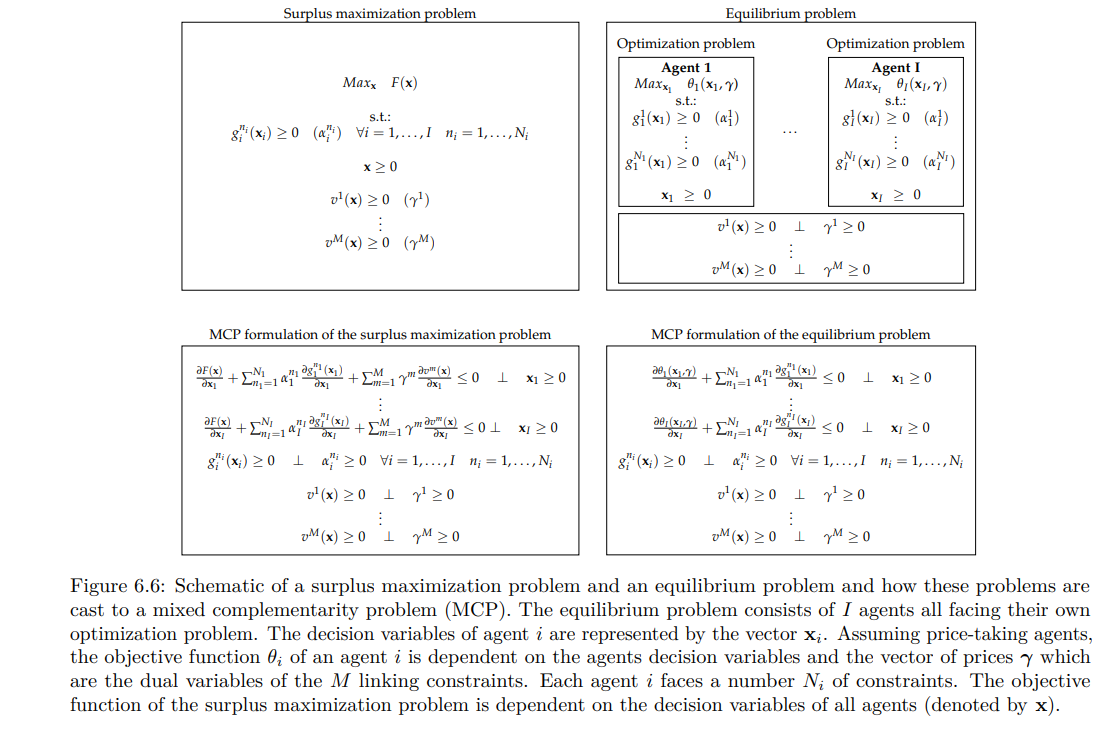

## 1. Central planner perspective
In what follows I will illustrate the differences between the formulations by means of the simplest example in energy system modelling: the economic dispatch problem. Below you can find an implementaion in Julia/JuMP of an economic dispatch problem using the "central planner perspective". In this case, a single objective function that consists of all the energy system costs will be minimized.

In [1]:
using JuMP
using Gurobi  # You can choose a different solver if you prefer

# Define the parameters of the problem
num_generators = 3
demand = 100  # Total electricity demand in MW

# Parameters for each generator
max_capacity = [50, 30, 40]  # Maximum power output for each generator in MW
marginal_cost = [20, 25, 30]  # Cost per unit power for each generator in EUR/MW

# Create a JuMP model
model = Model(Gurobi.Optimizer)

# Define set of generators
N = 1:num_generators

# Define decision variables
g = @variable(model, [n=N], lower_bound=0, base_name="generation" )

# Define the objective function (minimize total cost)
@objective(model, Min, sum(marginal_cost[n] * g[n] for n in N))

# Ensure that generators do not exceed their capacity
@constraint(model, [n=N], g[n] <= max_capacity[n])

# Ensure that the total power generated meets the demand
energy_balance = @constraint(model, sum(g[n] for n in N) == demand)

# Solve the optimization problem
optimize!(model)

# Print the results
println("Optimal Generation Schedule:")
for n in N
    println("Generator g_",n,": ",value(g[n])," MW")
end

println("Total Cost: ", objective_value(model), " EUR")

# Price can be extracted as the dual of the energy balance constraint
println("Electricity price: ", dual(energy_balance), " EUR/MWh")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-01
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 4 rows, 3 columns and 6 nonzeros
Model fingerprint: 0xda358450
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Presolve removed 4 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3500000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.350000000e+03

User-callback calls 35, time in user-callback 0.00 sec
Optimal Generation Schedule:
Generator g_1: 50.0 MW
Generator g_2: 30.0 MW
Generator g_3: 20.0 MW
Total Cost: 2350.0 EUR
Electricity price: 30.0 EUR/MWh


## 2. Multi-agent equilibrium perspective
In what follows we will solve the identical problem from the economic agents perspective, in which all generators try to maximize their profit. This multi-agent formulation is also called a multi-objective formulation (in contrast to the sigle-objective formulation we covered earlier). Mathematically speaking, the problem we will now describe is a mixed-complementary problem or MCP, a commonly encountered problem structure in Economics. 

In this case, each generator has its own objective function that resembles their costs, which it will aim to maximize.

In [2]:
N = 1:num_generators
model = Dict()
λ = 0

function init_model(model,N) 
    #Surpress Gurobi print-outs
    GUROBI_ENV = Gurobi.Env()
    GRBsetparam(GUROBI_ENV, "OutputFlag", "0")
    
    for n in N
        # Create a JuMP model for each agent
        model[n] =  Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV)))

        # Define decision variables
        g[n] = @variable(model[n], lower_bound=0, base_name="generation" )
        
        # Define the objective function (minimize total cost)
        @objective(model[n], Min, marginal_cost[n] * g[n] - λ * g[n])

        # Ensure that generators do not exceed their capacity
        @constraint(model[n], g[n] <= max_capacity[n])
        
    end
end

init_model(model,N)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-01


Note that we were not able to enforce the energy balance constraint yet, since that constraint does not belong to one particular agent but rather coordinates the actions of the agents. Such a contraint is called a market coupling constraint. In equilibrium modelling this constraint will be not explicitly modelled but rather we will attemt to find the equilibrium price λ at which this constraint is met. 

### 2.1 Heuristic to find λ
Next I will implement a simple heuristic that tries to find the equilibrium price λ. In this heuristic the price is adapted in proportion with the imbalance between supply and demand. If supply exceeds demand, the equilibrium price will be lower then the current price, hence the algortihm lowers the price in the next iteration. Vice versa if supply is lower than demand.

In [3]:
ρ = 1

λ_results = [0]
g_results = [[0], [0], [0]]


for i in 1:20
    for n in N 
        optimize!(model[n])
    end

    # We calculate the imbalance of the energy balance constraint
    imbalance = sum(value(g[n]) for n in N) - demand


    # ..and adjust the price proportional to the energy balance
    λ = λ - ρ/2 * imbalance
    
    # I am saving the prices for later reference
    push!(λ_results,λ)
    for n in N
        push!(g_results[n], value(g[n]))
    end
    
    for n in N
        #Update the objective function
        @objective(model[n], Min, marginal_cost[n] * g[n] - λ * g[n])
    end
end

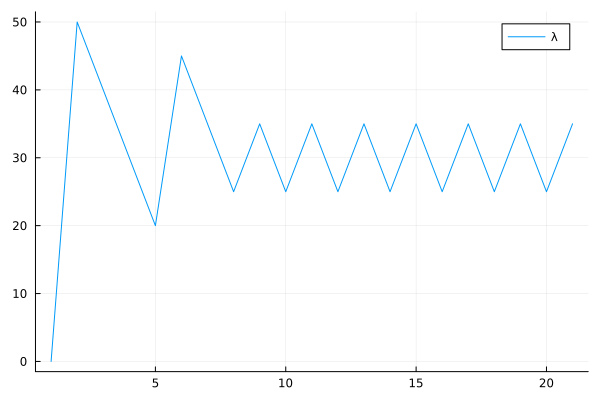

In [4]:
using Plots
plot(λ_results,label="λ")

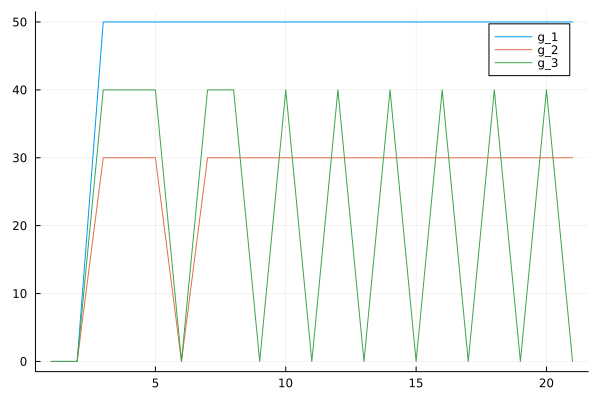

In [5]:
plot([g_results[1] g_results[2] g_results[3]],label=["g_1" "g_2" "g_3"])

It can be observed that this simple heuristic gets near the equilibrium price of 30 EUR/MWh but is unable to converge towards it. From inspecting the generation of the three generators we can deduct what is going on. Generator three, which sets the price jumps between being fully dispatched and not being dispatched at all. This happens because if the price rises above its marginal cost, it is optimal for the generator to be fully dispatched, and vice versa. To be able to reach equilibrium, convergence of the problem needs to be improved, which is possible using Augmented Lagranian Methods (https://en.wikipedia.org/wiki/Augmented_Lagrangian_method). One popular method is ADMM, of which we will show an example implementatio next.

### 2.2 Find λ using ADMM
The Alternating Direction Method of Multipliers (ADMM) is an optimization algorithm that is used to solve certain types of constrained optimization problems. It was developed as a way to efficiently solve problems with both smooth and non-smooth components, with convex objectives. ADMM is particularly well-suited for problems with a decentralized structure or those that can be split into subproblems that can be solved in parallel. The basic idea behind ADMM is to decompose a complex optimization problem into smaller, more manageable subproblems that can be solved sequentially or in parallel.

Convergence is improved by adding a penalty term to the objective which penalizes changes to the decision variables. This will ensure that the decision variables cannot oscillate as in the example above. Furthermore, the penalty term consists of a component proportional to the imbalance, this incentivises the agents to adjust their decision such that it resolves the imbalance.

A full ADMM implementation would include a convergance criterium which requires the primal residual (= mean square imbalance) and dual residual to be smaller than a certain δ. The dual residual is a measure of the change compared to  the previous iteration. This is ommited in this illustrative example.

In [6]:
N = 1:num_generators
model = Dict()
λ = 0.0
ρ = 1.0

λ_results = [0.0]
g_results = [[0.0], [0.0], [0.0]]
g_bar = zeros(num_generators)


init_model(model,N)

for i in 1:20
    for n in N 
        optimize!(model[n])
    end

    # We calculate the imbalance of the energy balance constraint
    imbalance = sum(value(g[n]) for n in N) - demand
    
    #primal_residual = imbalance
    #dual_residual = ρ*(g[n] - g_results[n])

    # ..and adjust the price proportional to the energy balance
    λ = λ - ρ/2 * imbalance
    
    # I am saving the prices for later reference
    push!(λ_results,λ)
    for n in N
        push!(g_results[n], value(g[n]))
    end
    
    for n in N
        #Update the objective function
        g_bar[n] = g_results[n][end] - 1/num_generators * imbalance
        @objective(model[n], Min, marginal_cost[n] * g[n] - λ * g[n] + ρ/2*(g[n]-g_bar[n][end])^2)
    end
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-01


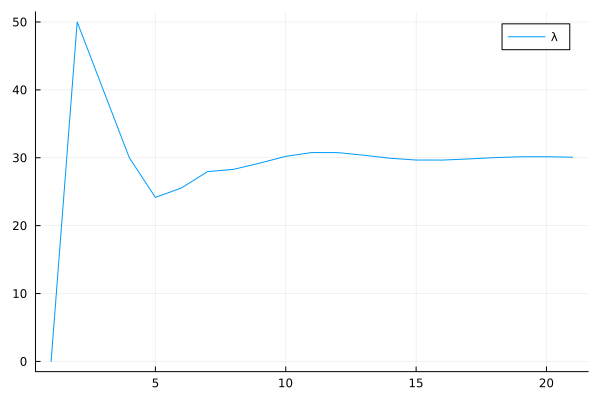

In [7]:
plot(λ_results,label="λ")

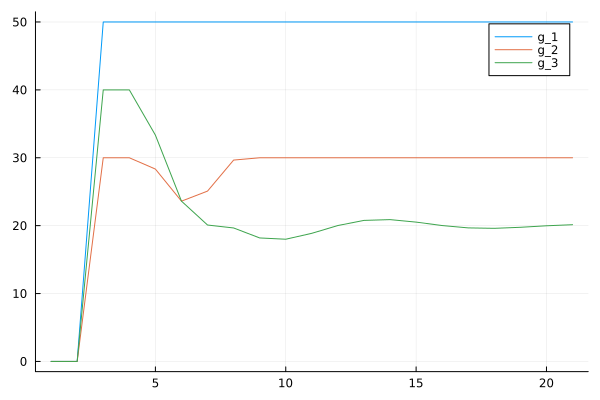

In [8]:
plot([g_results[1] g_results[2] g_results[3]],label=["g_1" "g_2" "g_3"])

## References
Orginal paper Boyd on ADMM:

- Boyd, Stephen. 2010. “Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers.” *Foundations and Trends® in Machine Learning* 3 (1): 1–122. https://doi.org/10.1561/2200000016.

Paper on how to apply ADMM to electricity markets:

- Höschle, Hanspeter, Hélène Le Cadre, Yves Smeers, Anthony Papavasiliou, and Ronnie Belmans. 2018. “An ADMM-Based Method for Computing Risk-Averse Equilibrium in Capacity Markets.” *IEEE Transactions on Power Systems* 33 (5): 4819–30. https://doi.org/10.1109/TPWRS.2018.2807738.

Example paper on coupling of multiple markets using ADMM (e.g. ETS and electricity):

- Bruninx, Kenneth, Marten Ovaere, and Erik Delarue. 2020. “The Long-Term Impact of the Market Stability Reserve on the EU Emission Trading System.” *Energy Economics* 89 (June): 104746. https://doi.org/10.1016/j.eneco.2020.104746.

Detailed description of PAC:

- Romvary, Jordan (Jordan Joseph). 2018. “A Proximal Atomic Coordination Algorithm for Distributed Optimization in Distribution Grids.” Thesis, Massachusetts Institute of Technology. https://dspace.mit.edu/handle/1721.1/117843.
